### Installing modules

In [1]:
!pip install 'google-cloud-bigquery<=1.22.0'
!pip install pandas_gbq
!pip install sagemaker_inference
!pip freeze

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
google-auth 1.13.1 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
google-auth 1.13.1 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
google-auth 1.13.1 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
alabaster==0.7.10
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
autovizwidget==0.15.0
awscli==1.18.24
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
bcrypt==3.1.7
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
blis==0.2.4
bokeh==1.0.4
bot

### Importing Modules

In [2]:
import numpy as np
import pandas as pd

import os
import boto3
import io

import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.predictor import RealTimePredictor

from google.oauth2 import service_account
import pandas_gbq

import pickle
import joblib

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

### Auth

In [3]:
# AWS - SageMaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
# create an S3 bucket
bucket = sagemaker_session.default_bucket()


# GCP - BigQuery
# load the service account credentials from S3
data_key = 'data-axe-106623-3075bd5900a3.json'
data_location = 's3://{}/credentials/{}'.format(bucket, data_key)
service_account_info = pd.read_json(data_location, typ='series') 
credentials = service_account.Credentials.from_service_account_info(
    service_account_info)

### Feature extraction

In [4]:
%load_ext google.cloud.bigquery

def feature_extraction_training_instances(num_instances):
    query = f"""


        WITH
          -- current ethereum balance for 1000 non-zero balance addresses
          ethereum_balance AS (
          SELECT
            address AS ethereum_address,
            (eth_balance / POWER(10, 18)) AS eth_balance
          FROM
            `bigquery-public-data.crypto_ethereum.balances`
          WHERE
            (eth_balance / POWER(10, 18)) > 1
          LIMIT
            {num_instances}),
          top_tokens AS (
          SELECT
            token_address,
            COUNT(1) AS transfer_count
          FROM
            `bigquery-public-data.ethereum_blockchain.token_transfers` AS token_transfers
          GROUP BY
            token_address
          ORDER BY
            transfer_count DESC
          LIMIT
            1000 ),
          token_balances AS (
          WITH
            double_entry_book AS (
            SELECT
              token_address,
              to_address AS ethereum_address,
              CAST(value AS float64) AS value,
              block_timestamp,
              transaction_hash
            FROM
              `bigquery-public-data.ethereum_blockchain.token_transfers`
            UNION ALL
            SELECT
              token_address,
              from_address AS ethereum_address,
              -CAST(value AS float64) AS value,
              block_timestamp,
              transaction_hash
            FROM
              `bigquery-public-data.ethereum_blockchain.token_transfers` )
          SELECT
            a.ethereum_address,
            b.token_address,
            SUM(value) AS balance,
            COUNT(DISTINCT transaction_hash) as unique_transfers
          FROM
            ethereum_balance a
          JOIN
            double_entry_book b
          ON
            a.ethereum_address = b.ethereum_address
          JOIN
            top_tokens c
          ON
            c.token_address = b.token_address
          WHERE
            a.ethereum_address != '0x0000000000000000000000000000000000000000'
          GROUP BY
            1,
            2
          HAVING
            balance > 0 )
        SELECT
          ethereum_address,
          MAX(eth_balance) AS ether_balance,
          COUNT(DISTINCT token_address) AS unique_tokens,
          MAX(unique_transfers) as unique_transfers
        FROM
          ethereum_balance a
        JOIN
          token_balances b
        USING
          (ethereum_address)
        GROUP BY
          1

    """

    # Pandas GBQ, wrapper
    # module provides a wrapper for Google’s BigQuery analytics web service

    address_features = pandas_gbq.read_gbq(query, credentials=credentials)
    return address_features

train_x_raw = feature_extraction_training_instances(num_instances=10000)
train_x_raw.head()

Downloading: 100%|██████████| 7858/7858 [00:01<00:00, 6668.59rows/s]


,ethereum_address,ether_balance,unique_tokens,unique_transfers
0,0x2197f17b70eca1812336271cba423790dfeb208b,1.031014,52,12
1,0x66ac8271b73a9bdd29cce88cdeb3f9059c7726e0,2.981019,27,10
2,0x652fc32507f9e582e6baaf004a8fc7ebf4fe777b,56.389620,22,10
3,0xeb5389f474c80f56dcb4fe5ae364689a19fadcc0,12.053714,24,10
4,0x95a45c11f197adcf6b6a49ca1f0f03d87304a076,42.518175,24,7


### EDA

In [7]:
train_x_raw.describe()

,ether_balance,unique_tokens,unique_transfers
count,7858.000000,7858.000000,7858.000000
mean,138.071879,6.541741,26.338636
std,4220.559372,8.204811,641.542926
min,1.000000,1.000000,1.000000
25%,2.024553,2.000000,1.000000
50%,4.526891,4.000000,1.000000
75%,12.541824,8.000000,1.000000
max,300001.020000,319.000000,28560.000000


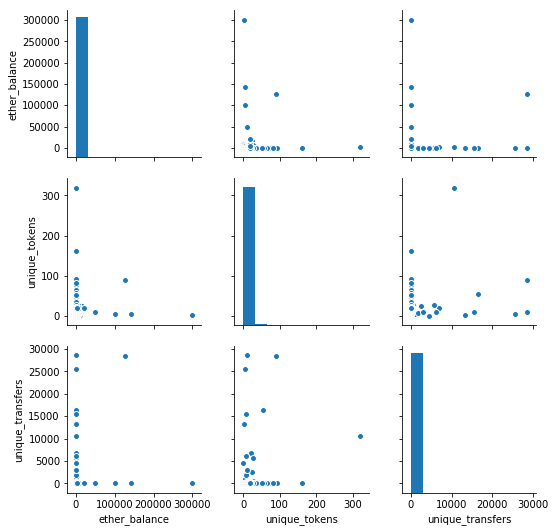

In [8]:
sns.pairplot(train_x_raw);

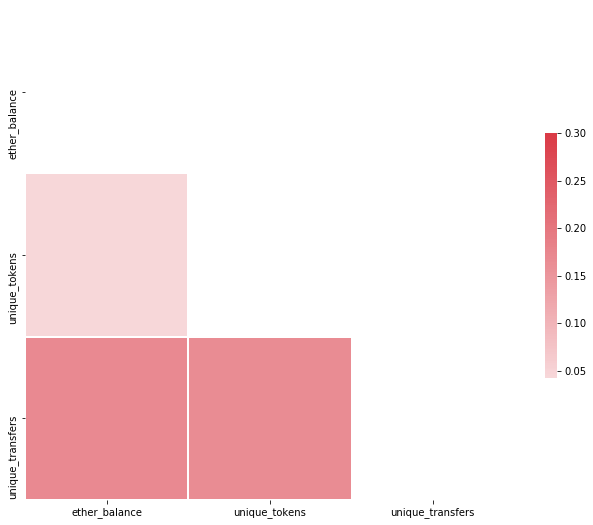

In [10]:
def plot_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
plot_correlation_matrix(train_x_raw)

# Pre-processing

In [11]:
num_clusters = 4
num_components = 3

train_x = train_x_raw.set_index('ethereum_address')
train_x.head()

,ether_balance,unique_tokens,unique_transfers
ethereum_address,,,
0x2197f17b70eca1812336271cba423790dfeb208b,1.031014,52,12
0x66ac8271b73a9bdd29cce88cdeb3f9059c7726e0,2.981019,27,10
0x652fc32507f9e582e6baaf004a8fc7ebf4fe777b,56.389620,22,10
0xeb5389f474c80f56dcb4fe5ae364689a19fadcc0,12.053714,24,10
0x95a45c11f197adcf6b6a49ca1f0f03d87304a076,42.518175,24,7


In [12]:
scaler = StandardScaler()
pca = PCA(n_components=num_components)
power_transform = PowerTransformer(standardize=False)
# build pipeline
pipe = Pipeline([('log', power_transform ),
                 ('scale', scaler ),
                 ('PCA', pca)]).fit(train_x)

train_x = pd.DataFrame(pipe.transform(train_x))

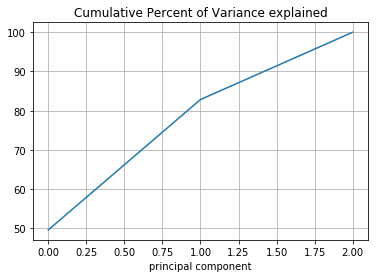

In [13]:
# Percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [15]:
train_x.head()

,0,1,2
0,2.540398,2.342118,-0.825063
1,2.512193,1.395435,-0.126884
2,3.038855,-0.388497,0.637418
3,2.832784,0.322749,0.328793
4,3.034892,-0.306578,0.526444


In [19]:
# save transformer locally

data_dir = 'feature_data'
filename ='transformer.pkl'

file_path = data_dir + '/' + filename

joblib.dump(pickle.dumps(pipe), file_path)
    
# upload transformer to S3

transformer = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=data_dir)
print(transformer)

s3://sagemaker-eu-west-1-831842320841/feature_data


In [20]:
# save features locally

data_dir = 'feature_data'
filename ='train.csv'

file_path = data_dir + '/' + filename
train_x.to_csv(file_path, header=False, index=False)

# upload features to S3

input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=data_dir)
print(input_data)

s3://sagemaker-eu-west-1-831842320841/feature_data


In [21]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

credentials/
credentials/data-axe-106623-3075bd5900a3.json
feature_data/train.csv
feature_data/transformer.pkl
sagemaker-scikit-learn-2020-04-12-13-45-44-771/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-15-55-42-197/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-16-00-17-241/debug-output/training_job_end.ts
sagemaker-scikit-learn-2020-04-12-16-00-17-241/output/model.tar.gz
sagemaker-scikit-learn-2020-04-12-16-00-17-241/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-16-05-36-024/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-16-28-16-265/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-16-37-24-811/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-17-17-55-827/debug-output/training_job_end.ts
sagemaker-scikit-learn-2020-04-12-17-17-55-827/output/model.tar.gz
sagemaker-scikit-learn-2020-04-12-17-17-55-827/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-04-12-17-21-31-538/sourcedir.tar.gz
Test passed!


# Clustering

In [22]:
### K-means

kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
kmeans_clusters = kmeans_model.fit_predict(train_x)

metrics.silhouette_score(train_x, kmeans_clusters, metric='euclidean')

0.3830658372663422

In [23]:
### GMM

gmm_model = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=0)
gmm_clusters = gmm_model.fit_predict(train_x)

metrics.silhouette_score(train_x, gmm_clusters, metric='euclidean')

0.3838588297855999

In [24]:
### Hierarchical

agg_model = AgglomerativeClustering(n_clusters=num_clusters)
agg_clusters = agg_model.fit_predict(train_x)

metrics.silhouette_score(train_x, agg_clusters, metric='euclidean')

0.3330430080064243

In [27]:
cluster_labels = kmeans_model.fit_predict(train_x)
# print cluster info for first data point
data_idx = 100

print(f"Ethereum address is: {train_x.index[data_idx]}")
print()
print(f"Predicted cluster: {cluster_labels[data_idx]}")

Ethereum address is: 100

Predicted cluster: 0


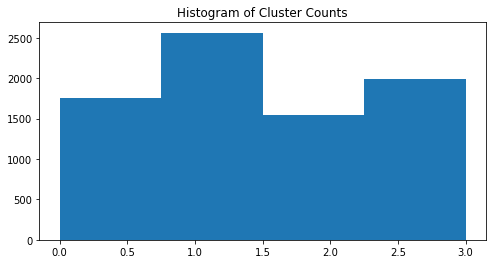

In [28]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax = plt.subplots(figsize=(8,4))
ax = plt.hist(cluster_labels, bins=num_clusters)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

## Training

In [29]:
# show training script code
!pygmentize source_sklearn/train.py

import os
import argparse
import pandas as pd

# clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# save the model
from sklearn.externals import joblib


# Model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")

    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")

    return model

if __name__ == '__main__':
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job

    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data and saving models; set automatically
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUT

In [30]:
estimator = SKLearn(entry_point="train.py",
                    source_dir="source_sklearn",
                    train_instance_type="ml.c4.xlarge",
                    role=role,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={'num-clusters': num_clusters})

In [31]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})

2020-04-13 17:52:12 Starting - Starting the training job...
2020-04-13 17:52:14 Starting - Launching requested ML instances......
2020-04-13 17:53:15 Starting - Preparing the instances for training...
2020-04-13 17:53:54 Downloading - Downloading input data...
2020-04-13 17:54:43 Training - Training image download completed. Training in progress.
2020-04-13 17:54:43 Uploading - Uploading generated training model2020-04-13 17:54:33,194 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-13 17:54:33,196 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-13 17:54:33,206 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-13 17:54:33,469 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-13 17:54:33,470 sagemaker-containers INFO     Generating setup.cfg
2020-04-13 17:54:33,470 sagemaker-containers INFO     Generating MANIFEST.in
2020

2020-04-13 17:54:42,551 sagemaker-containers INFO     Reporting training SUCCESS

2020-04-13 17:54:49 Completed - Training job completed
Training seconds: 55
Billable seconds: 55
CPU times: user 424 ms, sys: 49.2 ms, total: 473 ms
Wall time: 3min 11s


## Deployment

In [32]:
# if the training job has already been performed
training_job_name = estimator.latest_training_job.name
training_job_name

estimator = SKLearn.attach(training_job_name)
estimator

2020-04-13 17:54:49 Starting - Preparing the instances for training
2020-04-13 17:54:49 Downloading - Downloading input data
2020-04-13 17:54:49 Training - Training image download completed. Training in progress.
2020-04-13 17:54:49 Uploading - Uploading generated training model
2020-04-13 17:54:49 Completed - Training job completed2020-04-13 17:54:33,194 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-13 17:54:33,196 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-13 17:54:33,206 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-13 17:54:33,469 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-13 17:54:33,470 sagemaker-containers INFO     Generating setup.cfg
2020-04-13 17:54:33,470 sagemaker-containers INFO     Generating MANIFEST.in
2020-04-13 17:54:33,470 sagemaker-containers INFO     Installing module with the foll

In [33]:
estimator.model_data

's3://sagemaker-eu-west-1-831842320841/sagemaker-scikit-learn-2020-04-13-17-52-12-486/output/model.tar.gz'

In [36]:
# show prediction script code
!pygmentize source_sklearn/predict.py

import os
from io import StringIO, BytesIO
import argparse

from google.oauth2 import service_account

import numpy as np
import pandas as pd
import pandas_gbq
import s3fs

import sagemaker
from sagemaker_inference import encoder

# clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# save the model
from sklearn.externals import joblib

from utils import feature_extraction_individual_address

# accepts and returns json data
CONTENT_TYPE_INPUT = 'text/plain'
CONTENT_TYPE_OUTPUT = 'application/json'


# Model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")

    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")

    return model

def input_fn(serialized_input_data, content_type):
    print('Deserializing the input data.')
    if content_type 

In [37]:
%%time

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')
        
# Create a model from the trained estimator data
# And point to the prediction script
model = SKLearnModel(model_data=estimator.model_data, role=role,
    entry_point='predict.py', source_dir='source_sklearn', predictor_cls=StringPredictor)

# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------!CPU times: user 393 ms, sys: 26.8 ms, total: 420 ms
Wall time: 6min 32s


### Test the endpoint

In [41]:
sample_ethereum_address = '0xbd50da0bf9942e63b95676e7cf93597609636e5e'
predictor.predict(sample_ethereum_address)

b'0'

In [39]:
predictor.predict(sample_ethereum_address)

b'0'

In [42]:
predictor.endpoint

'sagemaker-scikit-learn-2020-04-13-17-58-47-500'

### Lambda function

In [43]:
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the address we were given
    response = runtime.invoke_endpoint(EndpointName = 'sagemaker-scikit-learn-2020-04-13-17-58-47-500',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # Ethereum address

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }

### Test Lambda function

In [44]:
event = {"body": '0xbd50da0bf9942e63b95676e7cf93597609636e5e'}

lambda_handler(event, None)

{'statusCode': 200,
 'headers': {'Content-Type': 'text/plain', 'Access-Control-Allow-Origin': '*'},
 'body': '0'}